In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem.cistem import Cistem
import string
import re
from textstat.textstat import *
import seaborn
from textblob_de import TextBlobDE as TextBlob
import autosklearn.classification
import sklearn.metrics
import random
import os
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

/home/mackenzie/anaconda3/lib/python3.7/site-packages/pyparsing.py:2725: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/mackenzie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Raw data
train_data = pd.read_csv("/home/mackenzie/Downloads/GermanTrainingData.txt", sep='\t', names=['tweet', 'coarse', 'labels'])
test_data = pd.read_csv("/home/mackenzie/Downloads/GermanTestingData.txt", sep='\t', names=['tweet', 'coarse', 'labels'])
df = pd.concat([train_data, test_data], ignore_index=True)
del train_data
del test_data

In [3]:
tweets=df.tweet

In [4]:
stopwords=stopwords = nltk.corpus.stopwords.words("german")

other_exclusions = ["lbr"]
stopwords.extend(other_exclusions)

stemmer = Cistem()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-ßA-ß]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-ßA-ß]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-ßA-ß.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=3000,
    min_df=5,
    max_df=0.75
    )

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [7]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [8]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=2000,
    min_df=5,
    max_df=0.75,
    )

In [9]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [10]:
#Now get other features

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-ßA-ß]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = TextBlob("tweet").sentiment
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words, lang='de_DE')
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment[0],twitter_objs[2], twitter_objs[1], twitter_objs[0]]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

# Changing string labels to numeric labels
def string_to_numeric(x):
    if x == 'OTHER' or x == 'PROFANITY':
        return 0
    if x == 'INSULT':
        return 1
    if x == 'ABUSE':
        return 2

In [11]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "sentiment", "num_hashtags", "num_mentions", "num_urls"]

In [12]:
feats = get_feature_array(tweets)

In [13]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [14]:
M.shape

(8407, 3918)

In [15]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [16]:
X = pd.DataFrame(M)
y = df['labels'].apply(string_to_numeric)
X.columns = feature_names

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [18]:
y_train = y_train.to_frame(name='labels')
y_test = y_test.to_frame(name='labels')

In [19]:
# can't run with columns more than 5000 or so it seems
print("start automl!")
automl = autosklearn.classification.AutoSklearnClassifier(ml_memory_limit=10000, time_left_for_this_task=360, per_run_time_limit=36) #ensemble_size=0)
automl.fit(X_train, y_train, dataset_name='english_data') # feat_type=classification is another param we might use?

/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)


start automl!


/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-07-25 11:08:33,855:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:33,875:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:35,899:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:37,907:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:39,947:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:41,954:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:43,959:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:45,973:EnsembleBuilder(1):english_data] No models better than random - using Dummy Score!
[WARNING] [2019-07-25 11:08:47,975:EnsembleBuilder(1):en

/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-07-25 11:13:14,480:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-07-25 11:13:14,480:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/mackenzie/anaconda3/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


1
['/tmp/autosklearn_tmp_23435_6299/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_tmp_23435_6299/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_tmp_23435_6299/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_tmp_23435_6299/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_tmp_23435_6299/.auto-sklearn/ensembles/1.0000000004.ensemble']


AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25, logging_config=None,
           metadata_directory=None, ml_memory_limit=10000, n_jobs=None,
           output_folder=None, per_run_time_limit=36,
           resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=360,
           tmp_folder=None)

In [20]:
y_hat = automl.predict(X_test)

In [25]:
print("Accuracy Score:", sklearn.metrics.accuracy_score(y_test, y_hat))
print("F1 score: ")
print(sklearn.metrics.f1_score(y_test, y_hat, average="weighted"))

Accuracy Score: 0.7455410225921522
F1 score: 
0.6911859977688347


In [26]:
automl.sprint_statistics() 

'auto-sklearn results:\n  Dataset name: english_data\n  Metric: accuracy\n  Best validation score: 0.718062\n  Number of target algorithm runs: 18\n  Number of successful target algorithm runs: 7\n  Number of crashed target algorithm runs: 3\n  Number of target algorithms that exceeded the time limit: 5\n  Number of target algorithms that exceeded the memory limit: 3\n'

Confusion Matrix: 
[[572   2  13]
 [ 73  14   6]
 [114   6  41]]
Recall: 


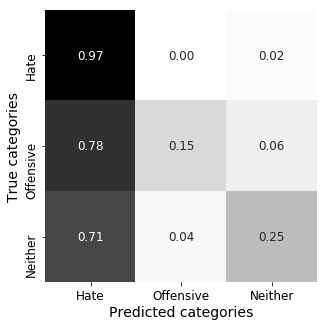

In [28]:
import matplotlib.pyplot as plt # TODO: take out once done checking
print("Confusion Matrix: ")
print(sklearn.metrics.confusion_matrix(y_test, y_hat))
print("Recall: ")

confusion_matrix = sklearn.metrics.confusion_matrix(y_test,y_hat)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
# Create a new folder to hold statistics for a run
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

# create a random folder number to reference the directory
rand = random.randint(0, 1000)*random.randint(0,10)
directory = '/home/mackenzie/workspace/PycharmProjects/DAADRISE_AbusiveLangProject/TestResults/Test_' + str(rand)
print('The results for this run will be stored in ' + directory)
createFolder(directory)

In [ ]:
# Saves the cv results to a csv in the folder specified
results = automl.cv_results_ #A dict with keys as column headers and values as columns, 
                             #that can be imported into a pandas DataFrame

# dict --> pandas dataframe
cv_results = pd.DataFrame.from_dict(results)
print('CV Results partially shown below')
print(cv_results.head())
cv_results.to_csv(directory+'/cv_results.csv')

In [ ]:
# Saves the model info to the directory specified
models = automl.get_models_with_weights() # Return a list of the final ensemble found by auto-sklearn.
model_info = pd.DataFrame.from_dict([models[0], models[1], models[2], models[3], models[4], models[5], models[6], models[7]])
                            #models[8], models[9], models[10], models[11]])
model_info.to_csv(directory+'/model_info.csv')
print('Model Results partially shown below')
print(models)